### In this notebook, we look at the data, and select the most relevant features for our task 
#### _Used the Vodafone dataset, which includes data about clients, their interaction with provide, other clients and applications_


In [1]:
import numpy as np
import pandas as pd
import pickle

from ydata_profiling import ProfileReport
import sweetviz as sv

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from mrmr import mrmr_classif

import umap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold,SelectKBest, f_classif, RFECV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import accuracy_score, log_loss, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from catboost import CatBoostClassifier

In [ ]:
pip install pandas==2.0.3

In [2]:
with open('age_model_pd2.pcl', 'rb') as f:
    age_model = pickle.load(f)

gen_info, train_data, test_data = age_model
train_info, df_train_fe, df_train_bnum, df_train_dpi = train_data

In [3]:
with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

In [4]:
with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

## Preprocessing

### Merge tables (connection many-to-many)

In [5]:
#create pivot table with abon_id and cnt_sms_in for short number for df_bnum
df_train_bnum_copy = df_train_bnum[['abon_id', 'bnum', 'cnt_sms_in']].copy()

#select 200 most popular numbers
top_200_bnum = df_train_bnum_copy['bnum'].value_counts().nlargest(200).index

with open('top_200_bnum.pkl', 'wb') as f:
    pickle.dump(top_200_bnum, f)

df_train_bnum_filtered = df_train_bnum_copy[df_train_bnum_copy['bnum'].isin(top_200_bnum)]

#encode columns name
unique_bnums = df_train_bnum_filtered['bnum'].unique()
bnum_to_id = {bnum: idx for idx, bnum in enumerate(unique_bnums)}
id_to_bnum = {idx: bnum for bnum, idx in bnum_to_id.items()} 

df_train_bnum_filtered['bnum_encoded'] = df_train_bnum_filtered['bnum'].map(bnum_to_id)
df_train_bnum_filtered.drop(columns='bnum', axis=0, inplace=True)

#create pivot table cnt_sms_in
df_train_bnum_pivot = df_train_bnum_filtered.pivot_table(
    index='abon_id',
    columns='bnum_encoded',
    values='cnt_sms_in',
    fill_value=0
)

df_train_bnum_pivot.columns = df_train_bnum_pivot.columns.map(id_to_bnum)

df_train_bnum_pivot = df_train_bnum_pivot.reset_index()

df_train_bnum_pivot.columns.name = None

df_train_bnum_pivot = df_train_bnum_pivot.add_suffix('_bnum')
df_train_bnum_pivot = df_train_bnum_pivot.rename(columns={'abon_id_bnum': 'abon_id'})

In [6]:
#create pivot table with abon_id and all columns in df_dpi
df_train_dpi_copy = df_train_dpi[['abon_id', 'Application', 'SUM_of_Duration_sec', 
                                  'SUM_of_Volume_kb', 'SUM_of_Count_events', 'MAX_of_day_cnt']].copy()

#select 200 most popular application
top_200_dpi = df_train_dpi_copy['Application'].value_counts().nlargest(200).index
with open('top_200_dpi.pkl', 'wb') as f:
    pickle.dump(top_200_dpi, f)

df_train_dpi_filtered = df_train_dpi_copy[df_train_dpi_copy['Application'].isin(top_200_dpi)]

#create pivot table for each feature
pivot_duration = df_train_dpi_filtered.pivot_table(index='abon_id', columns='Application', 
                                                   values='SUM_of_Duration_sec', fill_value=0).reset_index()
pivot_volume = df_train_dpi_filtered.pivot_table(index='abon_id', columns='Application', 
                                                 values='SUM_of_Volume_kb', fill_value=0).reset_index()
pivot_count_events = df_train_dpi_filtered.pivot_table(index='abon_id', columns='Application', 
                                                       values='SUM_of_Count_events', fill_value=0).reset_index()
pivot_day_cnt = df_train_dpi_filtered.pivot_table(index='abon_id', columns='Application', 
                                                  values='MAX_of_day_cnt', fill_value=0).reset_index()

pivot_duration.columns.name = None
pivot_volume.columns.name = None
pivot_count_events.columns.name = None
pivot_day_cnt.columns.name = None

pivot_duration = pivot_duration.add_suffix('_duration')
pivot_volume = pivot_volume.add_suffix('_volume')
pivot_count_events = pivot_count_events.add_suffix('_count_events')
pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')

pivot_duration = pivot_duration.rename(columns={'abon_id_duration': 'abon_id'})
pivot_volume = pivot_volume.rename(columns={'abon_id_volume': 'abon_id'})
pivot_count_events = pivot_count_events.rename(columns={'abon_id_count_events': 'abon_id'})
pivot_day_cnt = pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'})

#merge 
df_train_dpi_pivot = pivot_duration.merge(pivot_volume, on='abon_id')
df_train_dpi_pivot = df_train_dpi_pivot.merge(pivot_count_events, on='abon_id')
df_train_dpi_pivot = df_train_dpi_pivot.merge(pivot_day_cnt, on='abon_id')

#rename column (we have the same one in  bnum table)
if '1020_duration' in df_train_dpi_pivot.columns:
    df_train_dpi_pivot.rename(columns={'1020_duration': '1020_app'}, inplace=True)

In [7]:
#merge
df_train_fe_merged_1 = pd.merge(df_train_fe, df_train_bnum_pivot, on='abon_id', how='left')

new_columns_1 = df_train_fe_merged_1.columns.difference(df_train_fe.columns)
df_train_fe_merged_1[new_columns_1] = df_train_fe_merged_1[new_columns_1].fillna(0) 

df_train_fe_merged_2 = pd.merge(df_train_fe_merged_1, df_train_dpi_pivot, on='abon_id', how='left')

new_columns_2 = df_train_fe_merged_2.columns.difference(df_train_fe_merged_1.columns)
df_train_fe_merged_2[new_columns_2] = df_train_fe_merged_2[new_columns_2].fillna(0)

df_train = df_train_fe_merged_2.copy()
df_train.columns = df_train.columns.map(str)

In [8]:
df_train.head(5)

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,2048_day_cnt,2536_day_cnt,2542_day_cnt,2543_day_cnt,2555_day_cnt,2558_day_cnt,2568_day_cnt,2569_day_cnt,2573_day_cnt,2577_day_cnt
0,0.0,0.0,10.831324,1.001231,1.000303,5.324077,0.0,31.451311,1.226911,25.836335,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,9.974412,1.000840,1.000147,5.324077,0.0,0.000000,1.006293,13.330951,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,12.103587,1.001149,1.000765,5.324077,0.0,10.624526,1.009837,4.981543,...,0.0,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,21.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,1.480453,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Devide into train and test

In [9]:
df_train['target'] = df_train['target'].astype(dtype=np.int8)

y = df_train['target']
X = df_train.drop(columns='target', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
y.value_counts()

target
3    39579
4    31692
5    29294
2    27428
1    18960
Name: count, dtype: int64

### Classes(target) distribution

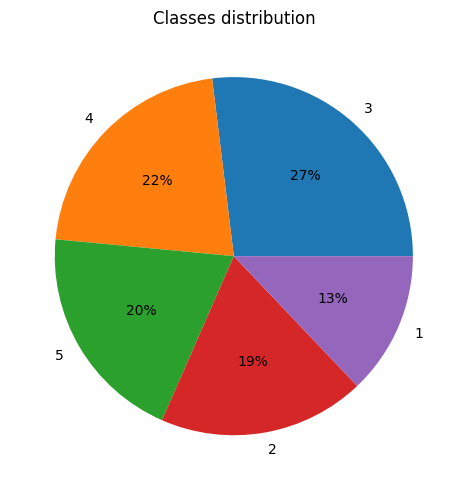

In [11]:
class_dstr = pd.DataFrame(y_train.value_counts()).reset_index()

plt.figure(figsize=(5, 5))

plt.pie(class_dstr['count'], labels = class_dstr['target'], autopct='%1.f%%')
plt.title('Classes distribution')

plt.tight_layout()
plt.show()

### X_train preprocessing

In [12]:
#delete abon id column
X_train.drop(axis=0, columns='abon_id', inplace=True)
X_train.drop(axis=0, columns='CALCULATION_METHOD_ID', inplace=True)

In [13]:
#delete missing >75%
na_ratio = X_train.isna().mean()
columns_to_drop = na_ratio[na_ratio > 0.75].index

X_train.drop(axis=0, columns=columns_to_drop, inplace=True)

In [14]:
#drop constant features
from sklearn.feature_selection import VarianceThreshold

select_featur_var = VarianceThreshold(threshold=0.01)
select_featur_var.fit(X_train)

selected_features = X_train.columns[select_featur_var.get_support()]
not_selected_features = [x for x in X_train.columns if x not in selected_features]

X_train.drop(columns=not_selected_features, axis=0, inplace=True)

In [15]:
#for boolean missing - fill with moda
bool_columns = [col for col in X_train.columns if set(X_train[col].dropna().unique()).issubset({0, 1})]

features_mode = bool_columns
mode_dict = {}

for feature in features_mode:
    mode_value = X_train[feature].mode()
    mode_dict[feature] = mode_value

for feature in features_mode:
    X_train[feature] = X_train[feature].fillna(mode_dict[feature])

with open('mode_dict.pkl', 'wb') as f:
    pickle.dump(mode_dict, f)

In [16]:
#median
features_median = X_train.columns[X_train.isna().any()].tolist()
median_dict = {}

for feature in features_median:
    median_value = X_train[feature].median()
    median_dict[feature] = median_value

for feature in features_median:
    X_train[feature] = X_train[feature].fillna(median_dict[feature])

with open('median_dict.pkl', 'wb') as f:
    pickle.dump(median_dict, f)

In [17]:
#preprocess validation set 
def preprocessing_valid(validation_set, selected_feature):

    X_val = validation_set[selected_feature]

    #boolean    
    with open('mode_dict.pkl', 'rb') as f:
        mode_dict = pickle.load(f) 
    
    for feature in X_val.columns:
        if feature in mode_dict:
            X_val[feature] = X_val[feature].fillna(mode_dict[feature])
    
    
    with open('median_dict.pkl', 'rb') as f:
        median_dict = pickle.load(f) 
    
    for feature in X_val.columns:
        if feature in median_dict:
            X_val[feature] = X_val[feature].fillna(median_dict[feature])
        
    return X_val

In [18]:
X_valid = preprocessing_valid(X_valid, X_train.columns)

### Test on full set

Accuracy_train: 0.6346355919540969
Accuracy_val: 0.5523140961001649

F1_train: 0.6207936729588939
Fi_val: 0.531995853813883


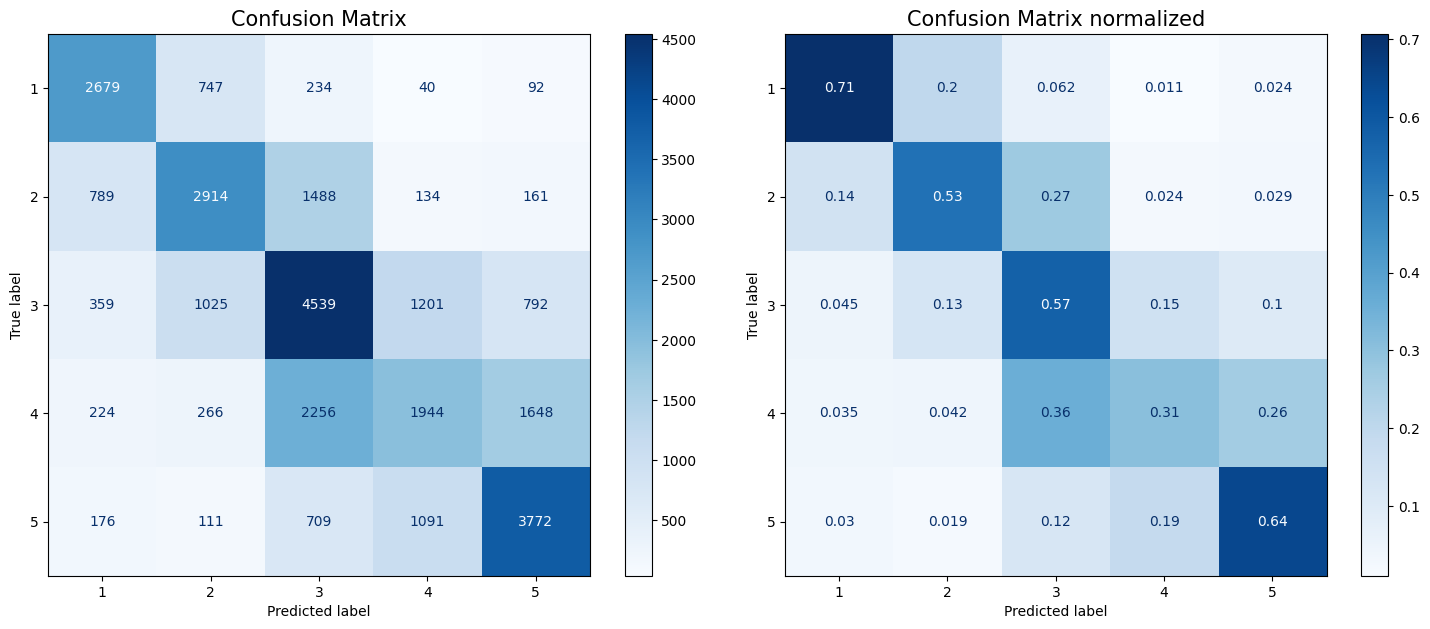

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import lightgbm as lgb

model = CatBoostClassifier(random_state=22, verbose=0)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_val = model.predict(X_valid)

proba_train = model.predict_proba(X_train)
proba_val = model.predict_proba(X_valid)

balanced_accuracy_train = balanced_accuracy_score(y_train, pred_train)
balanced_accuracy_val = balanced_accuracy_score(y_valid, pred_val)

f1_score_train = f1_score(y_train, pred_train, average='weighted')
f1_score_val = f1_score(y_valid, pred_val, average='weighted')


print(f'Accuracy_train: {balanced_accuracy_train}')
print(f'Accuracy_val: {balanced_accuracy_val}\n')

print(f'F1_train: {f1_score_train}')
print(f'Fi_val: {f1_score_val}')

cm = confusion_matrix(y_valid, pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

cm_normalized = confusion_matrix(y_valid, pred_val, normalize='true')
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

disp.plot(ax=axs[0], cmap='Blues',)
axs[0].set_title('Confusion Matrix', size = 15)

disp_normalized.plot(ax=axs[1], cmap='Blues')
axs[1].set_title('Confusion Matrix normalized', size = 15)

plt.tight_layout()
plt.show()

# Feature selection 

## MRMR

In [20]:
X_train_mrmr, _, y_train_mrmr, _ = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

selected_features_mrmr = mrmr_classif(X=X_train_mrmr, y=y_train_mrmr, K=400)

100%|█████████████████████████████████████████| 400/400 [11:48<00:00,  1.77s/it]


In [22]:
with open('selected_features_mrmr.pkl', 'wb') as f:
    pickle.dump(selected_features_mrmr, f)

## RF & ANOVA & MI

### ANOVA

In [23]:
#choose continuous variables
boolean_features = [column for column in X_train.columns if X_train[column].nunique() == 2]
X_train_anova = X_train.drop(columns= boolean_features, axis=0)

In [24]:
pt = PowerTransformer(standardize=False)

X_train_anova_normalized = pt.fit_transform(X_train_anova)
X_train_anova_normalized_df = pd.DataFrame(X_train_anova_normalized, columns=X_train_anova.columns)

In [25]:
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_anova_normalized_df, y_train)

score = selector.scores_

anova_scores = pd.DataFrame({'Feature': X_train_anova_normalized_df.columns, 'Anova': score})
anova_scores = anova_scores.sort_values(by='Anova', ascending=False)
anova_scores['Anova'] = anova_scores['Anova'] / anova_scores['Anova'].max()


In [26]:
anova_scores.head(10)

,Feature,Anova
563,lt,1.000000
572,imei_mean_long_days_usage,0.771515
570,imei_mean_days_usage,0.698353
1277,320_count_events,0.402409
1477,320_day_cnt,0.398208
877,320_duration,0.393751
1077,320_volume,0.373872
1447,2542_count_events,0.331363
1647,2542_day_cnt,0.331354
1247,2542_volume,0.331326


### Mutual information

In [27]:
#find features with the biggest mutual information for each class
from sklearn.feature_selection import mutual_info_classif


mi_target = pd.get_dummies(y_train, prefix='target')

def mi_df (df, target):
    
    mutual_info = mutual_info_classif(df, target)
    
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X_train.columns
    
    return mutual_info

mi_c1 = mi_df(X_train, mi_target['target_1'])
mi_c2 = mi_df(X_train, mi_target['target_2'])
mi_c3 = mi_df(X_train, mi_target['target_3'])
mi_c4 = mi_df(X_train, mi_target['target_4'])
mi_c5 = mi_df(X_train, mi_target['target_5'])

In [28]:
mi_scores = pd.DataFrame({'mi_c1': mi_c1, 'mi_c2': mi_c2, 'mi_c3': mi_c3, 'mi_c4': mi_c4, 'mi_c5': mi_c5})

mi_scores['MI'] = mi_scores.sum(axis=1)

mi_scores = mi_scores.reset_index()
mi_scores = mi_scores.rename(columns={"index": "Feature"})
mi_scores = mi_scores.drop(columns= ['mi_c1', 'mi_c2', 'mi_c3', 'mi_c4', 'mi_c5' ], axis = 0)
mi_scores['MI'] = mi_scores['MI'] / mi_scores['MI'].max()

mi_scores = mi_scores.sort_values(by='MI', ascending=False)


In [29]:
mi_scores.head(10)

,Feature,MI
566,lt,1.000000
572,device_has_wifi,0.818931
1141,814_volume,0.738464
586,imei_mean_long_days_usage,0.733243
581,imei_mean_days_usage,0.694729
582,device_type_smartphone,0.675852
941,814_duration,0.643556
583,device_type_rus_other,0.599718
579,device_brand_other,0.588950
598,is_avg_paym,0.587784


### Random Forest

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'RF_importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='RF_importance', ascending=False)
feature_importance_df['RF_importance'] = feature_importance_df['RF_importance'] / feature_importance_df['RF_importance'].max()

In [31]:
feature_importance_df.head(10)

,Feature,RF_importance
566,lt,1.000000
586,imei_mean_long_days_usage,0.831915
581,imei_mean_days_usage,0.828122
564,Balance_uah,0.509709
575,imei_mean_price,0.500978
584,imei_mean_day_announced,0.495010
567,myvf_day_usage,0.482844
576,imei_max_price,0.456261
561,days_of_end_last_ppm,0.455727
562,days_of_last_ppm,0.450445


### Merge results

In [32]:
combined_scores = pd.merge(mi_scores, anova_scores, on='Feature', how='left')
combined_scores = pd.merge(combined_scores, feature_importance_df, on='Feature', how='left')

In [33]:
combined_scores['Total_Boolean'] = np.where(combined_scores['Feature'].isin(boolean_features),
                                  (combined_scores['MI'] + combined_scores['RF_importance']) / 2,
                                  np.nan)

combined_scores['Total_Continuous'] = np.where(combined_scores['Feature'].isin(X_train_anova.columns),
                                  (combined_scores['MI'] + combined_scores['Anova'] + combined_scores['RF_importance']) / 3,
                                  np.nan)

In [34]:
combined_scores['Total']= combined_scores[['Total_Continuous', 'Total_Boolean']].sum(axis=1, skipna=True)
combined_scores = combined_scores.drop(columns = ['Total_Continuous', 'Total_Boolean'], axis=0)

combined_scores = combined_scores.reset_index().set_index('Feature', drop=True)
combined_scores = combined_scores.drop(columns= 'index', axis=0)

combined_scores = combined_scores.sort_values(by='Total', ascending=False)

In [35]:
combined_scores.head(15)

,MI,Anova,RF_importance,Total
Feature,,,,
lt,1.000000,1.000000,1.000000,1.000000
imei_mean_long_days_usage,0.733243,0.771515,0.831915,0.778891
imei_mean_days_usage,0.694729,0.698353,0.828122,0.740401
814_volume,0.738464,0.180619,0.388407,0.435830
device_has_wifi,0.818931,NaN,0.007461,0.413196
814_count_events,0.572378,0.242239,0.340227,0.384948
imei_mean_price,0.424099,0.218346,0.500978,0.381141
814_duration,0.643556,0.173124,0.279854,0.365511
device_type_smartphone,0.675852,NaN,0.006047,0.340949


In [36]:
combined_scores.to_csv("combined_features_scores.csv")

## Show diff between MRMR and RF & ANOVA & MI

In [37]:
set_mrmr = set(selected_features_mrmr)

anv_mi_rf = combined_scores.index[:400].tolist()
set_anv_mi_rf = set(anv_mi_rf)

In [38]:
#print(set_mrmr - set_anv_mi_rf)

In [39]:
#print(set_anv_mi_rf - set_mrmr)

### Reduce features amount with RFE for mrmr

In [40]:
X_train_rfe_temp = X_train[selected_features_mrmr]

X_train_rfe, _, y_train_rfe, _ = train_test_split(X_train_rfe_temp, y_train, test_size=0.2, stratify=y_train, random_state=42)


dtc = DecisionTreeClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=dtc,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=100,
    n_jobs=-1,
)
rfecv.fit(X_train_rfe, y_train_rfe)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 391


In [41]:
selected_features_mrmr_rfe = X_train_rfe.columns[rfecv.support_]

#print("Selected features:")
#for feature in selected_features_mrmr_rfe:
#    print(feature)

In [42]:
with open('selected_features_mrmr_rfe.pkl', 'wb') as f:
    pickle.dump(selected_features_mrmr_rfe, f)

## Reduce features amount with RFE for anova&mi&rf

In [43]:
selected_feature_anova = combined_scores.index[:300].tolist()
X_train_anova_temp = X_train[selected_feature_anova]

X_train_anova_rfe, _, y_train_anova_rfe, _ = train_test_split(X_train_anova_temp, y_train, test_size=0.2, stratify=y_train, random_state=42)


dtc = DecisionTreeClassifier()
cv = StratifiedKFold(5)

rfecv_anova = RFECV(
    estimator=dtc,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=100,
    n_jobs=-1,
)
rfecv_anova.fit(X_train_anova_rfe, y_train_anova_rfe)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), min_features_to_select=100, n_jobs=-1,
      scoring='accuracy')

In [44]:
print(f"Optimal number of features: {rfecv_anova.n_features_}")

Optimal number of features: 260


In [45]:
selected_features_anova_rfe = X_train_anova_rfe.columns[rfecv_anova.support_]

#print("Selected features:")
#for feature in selected_features_anova_rfe:
#    print(feature)

In [46]:
with open('selected_features_anova_rfe.pkl', 'wb') as f:
    pickle.dump(selected_features_anova_rfe, f)

### Save datasets for training model

In [47]:
X_train[selected_features_mrmr_rfe].to_csv("X_train_mrmr.csv")
X_valid[selected_features_mrmr_rfe].to_csv("X_valid_mrmr.csv")

X_train[selected_features_anova_rfe].to_csv("X_train_anova.csv")
X_valid[selected_features_anova_rfe].to_csv("X_valid_anova.csv")

y_train.to_csv("y_train.csv")
y_valid.to_csv("y_valid.csv")

## Visualize classes wich choosen features 

### To understand the result of the confusion matrix(why 4th class is similar to 3rd and 5th)

In [48]:
X_visual = X_train[selected_features_anova_rfe]

X_sample_pca, _, y_sample_pca, _ = train_test_split(X_visual, y_train, train_size=0.2, stratify=y_train, random_state=42)

scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(X_sample_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_pca)

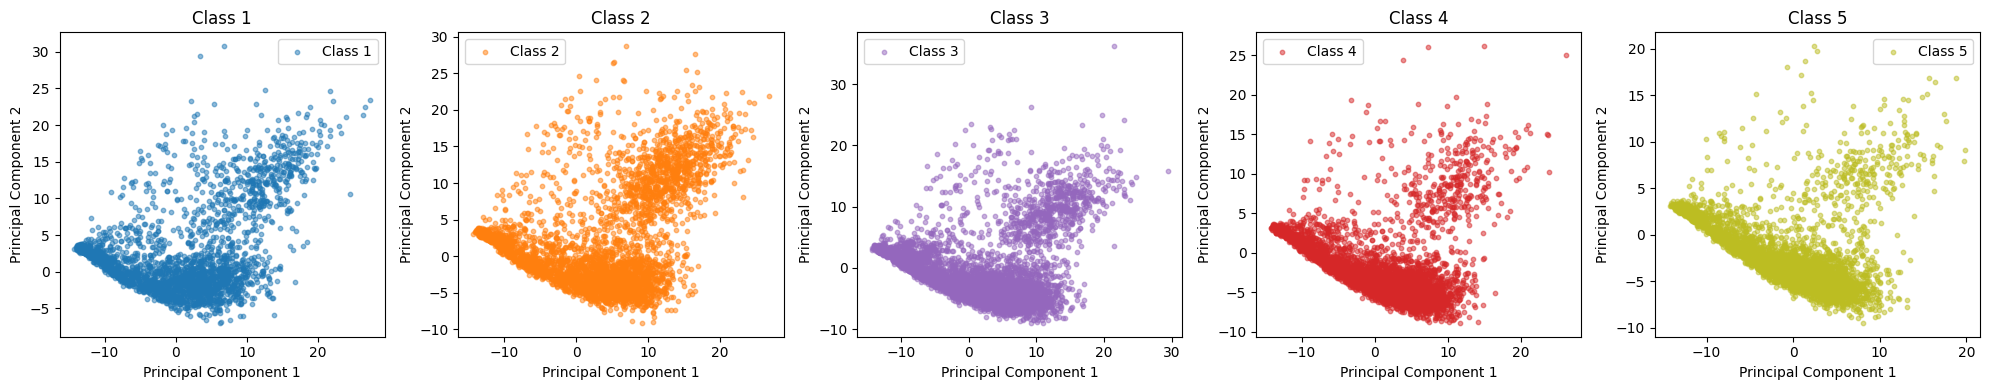

In [49]:
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:olive']

fig, axs = plt.subplots(1, 5, figsize=(20, 4)) 

for i in range(5):
    axs[i].scatter(X_pca[y_sample_pca == i+1, 0], X_pca[y_sample_pca == i+1, 1], c=colors[i], label=f'Class {i+1}', alpha=0.5, s=10)
    axs[i].set_title(f'Class {i+1}')
    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    axs[i].legend()

plt.tight_layout()
plt.show()

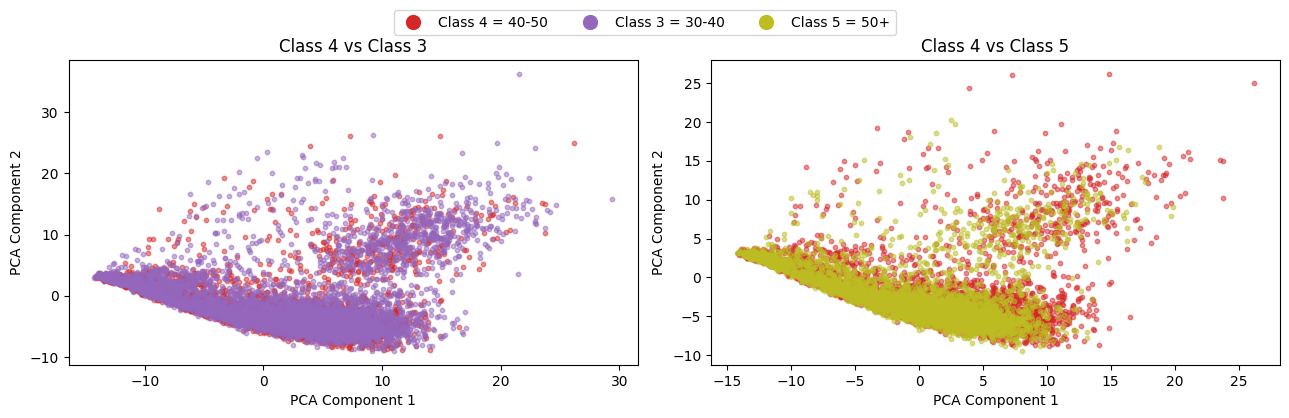

In [50]:
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:olive']
class_names = [f'Class {i}' for i in range(1, 6)]

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

classes_to_compare = [3, 5]
class_to_plot = 4

for idx, comp_class in enumerate(classes_to_compare):
    axs[idx].scatter(X_pca[y_sample_pca == class_to_plot, 0], X_pca[y_sample_pca == class_to_plot, 1], 
                     c=colors[class_to_plot - 1], alpha=0.5, s=10, label=class_names[class_to_plot - 1])
    axs[idx].scatter(X_pca[y_sample_pca == comp_class, 0], X_pca[y_sample_pca == comp_class, 1], 
                     c=colors[comp_class - 1], alpha=0.5, s=10, label=class_names[comp_class - 1])
    axs[idx].set_title(f'{class_names[class_to_plot - 1]} vs {class_names[comp_class - 1]}')
    axs[idx].set_xlabel('PCA Component 1')
    axs[idx].set_ylabel('PCA Component 2')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[class_to_plot - 1], markersize=12, label=f'{class_names[class_to_plot - 1]} = 40-50'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[classes_to_compare[0] - 1], markersize=12, label=f'{class_names[classes_to_compare[0] - 1]} = 30-40'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[classes_to_compare[1] - 1], markersize=12, label=f'{class_names[classes_to_compare[1] - 1]} = 50+')
]
fig.legend(handles=handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

_It is easy to see that clients from 3,4,5 are similar, which means they have similar behaviour_

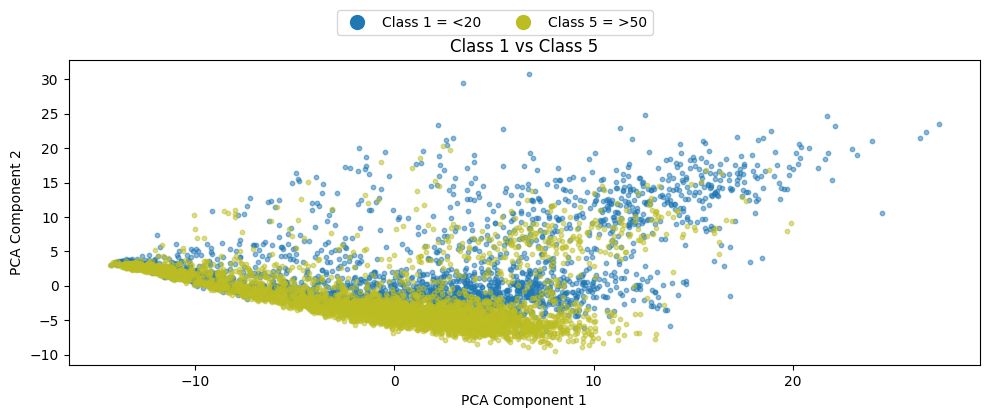

In [51]:
fig, ax = plt.subplots(figsize=(10, 4))

classes_to_compare = [1, 5]

for comp_class in classes_to_compare:
    ax.scatter(X_pca[y_sample_pca == comp_class, 0], X_pca[y_sample_pca == comp_class, 1], 
               c=colors[comp_class - 1], alpha=0.5, s=10, label=f'{class_names[comp_class - 1]}')

ax.set_title(f'{class_names[1 - 1]} vs {class_names[5 - 1]}')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1 - 1], markersize=12, label='Class 1 = <20'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[5 - 1], markersize=12, label='Class 5 = >50')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

_Meantime, the difference between classes 1 and 5 is huge, points do not overlap each other_

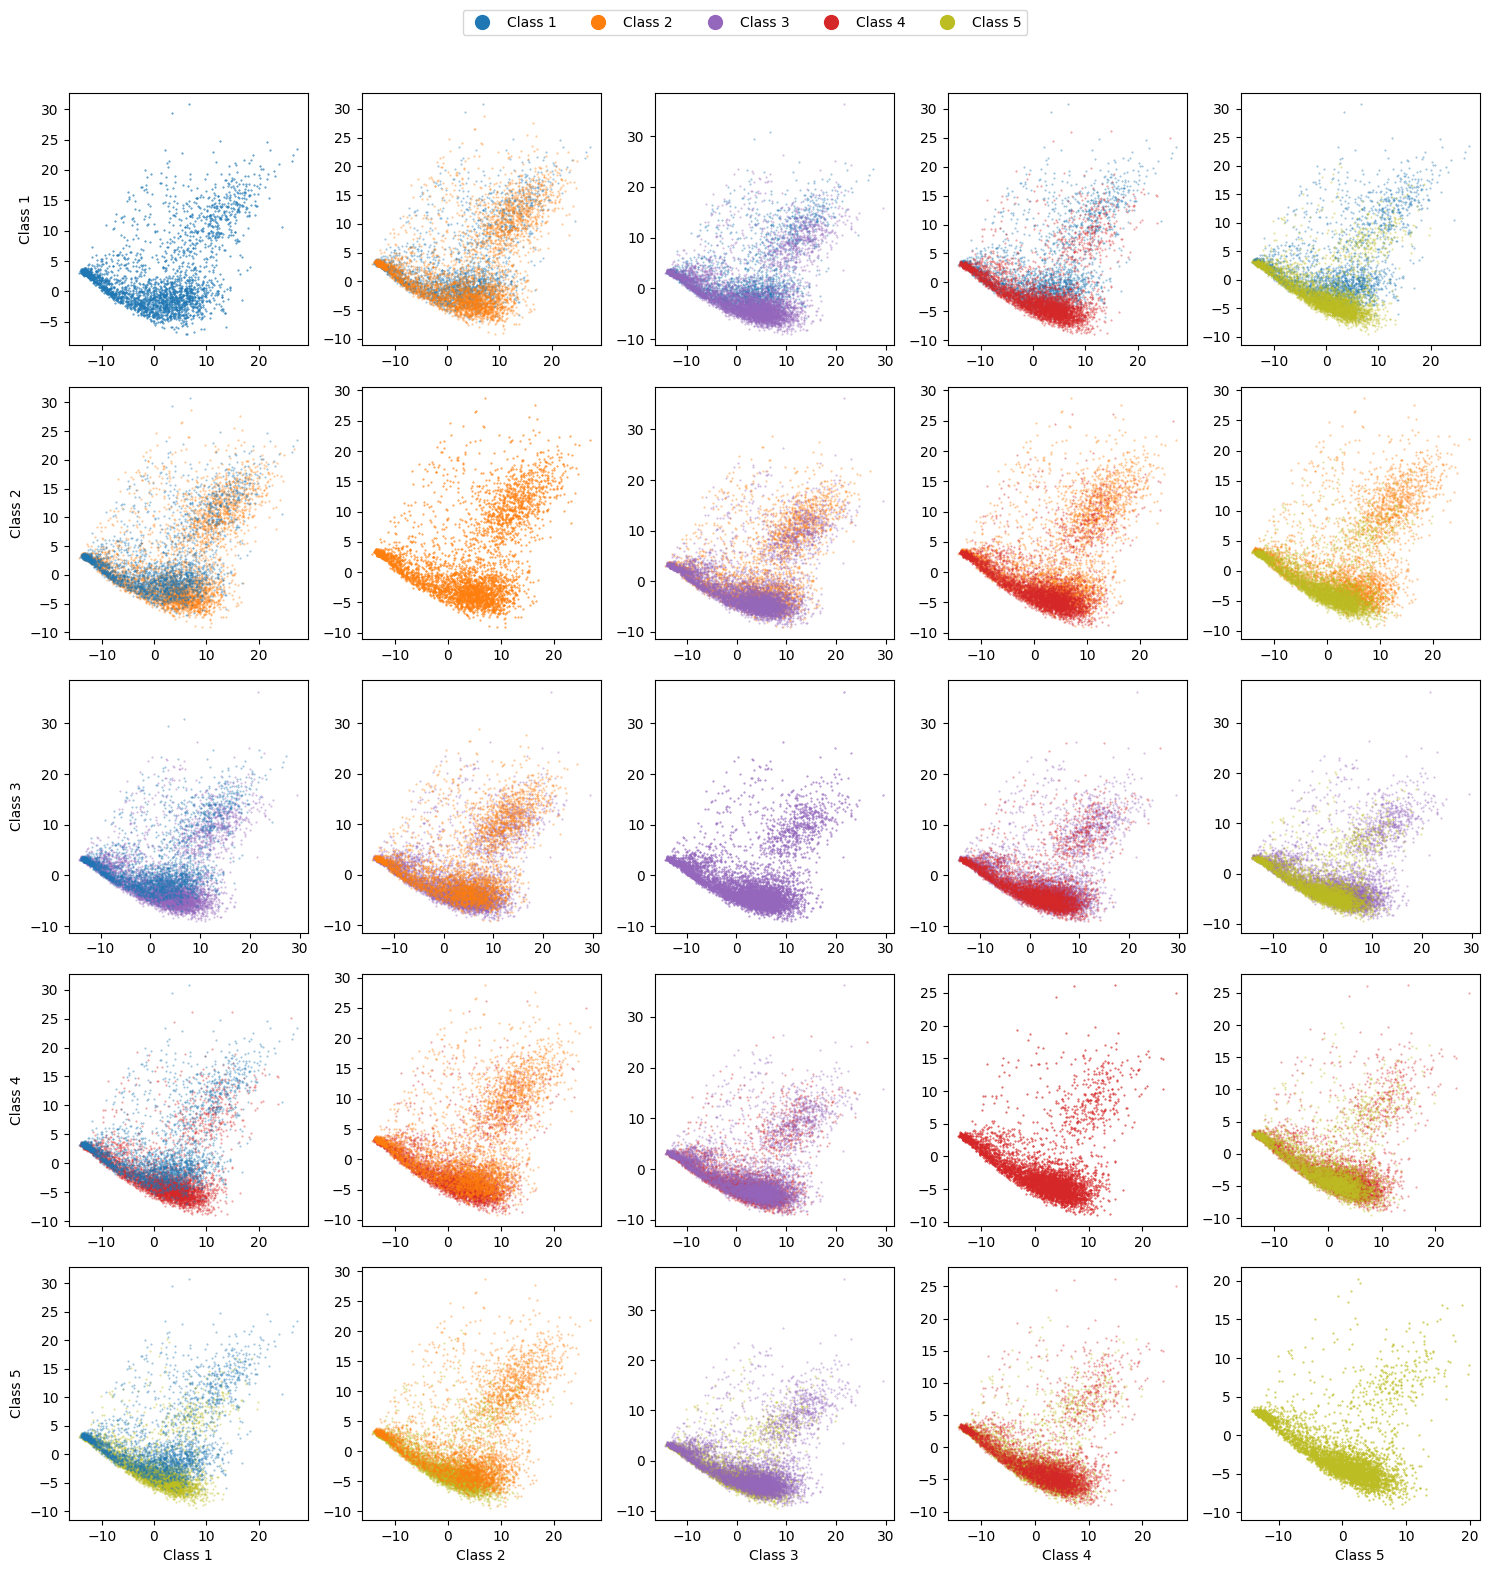

In [52]:
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:olive']

fig, axs = plt.subplots(5, 5, figsize=(15, 15))

class_names = [f'Class {i}' for i in range(1, 6)]

for i in range(1, 6):  
    for j in range(1, 6):
        row = i - 1
        col = j - 1
        axs[row, col].scatter(X_pca[y_sample_pca == i, 0], X_pca[y_sample_pca == i, 1], c=colors[i - 1], alpha=0.5, s=0.2)
        axs[row, col].scatter(X_pca[y_sample_pca == j, 0], X_pca[y_sample_pca == j, 1], c=colors[j - 1], alpha=0.5, s=0.2)
        if col == 0:
            axs[row, col].set_ylabel(class_names[row])
        if row == 4:
            axs[row, col].set_xlabel(class_names[col])


handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=class_name) for class_name, color in zip(class_names, colors)]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()  
plt.show()

### Visualize a few features

In [54]:
X_eda = X[['lt','data_3g_tar_vol_mea_mnt3', 'imei_mean_price', 'Balance_uah']]
X_eda.rename(columns = {'lt':'Life time', 'data_3g_tar_vol_mea_mnt3':'3G volume',
                              'imei_mean_price':'Device price', 'Balance_uah':'Balance uah'}, inplace = True)
X_eda['target'] = y

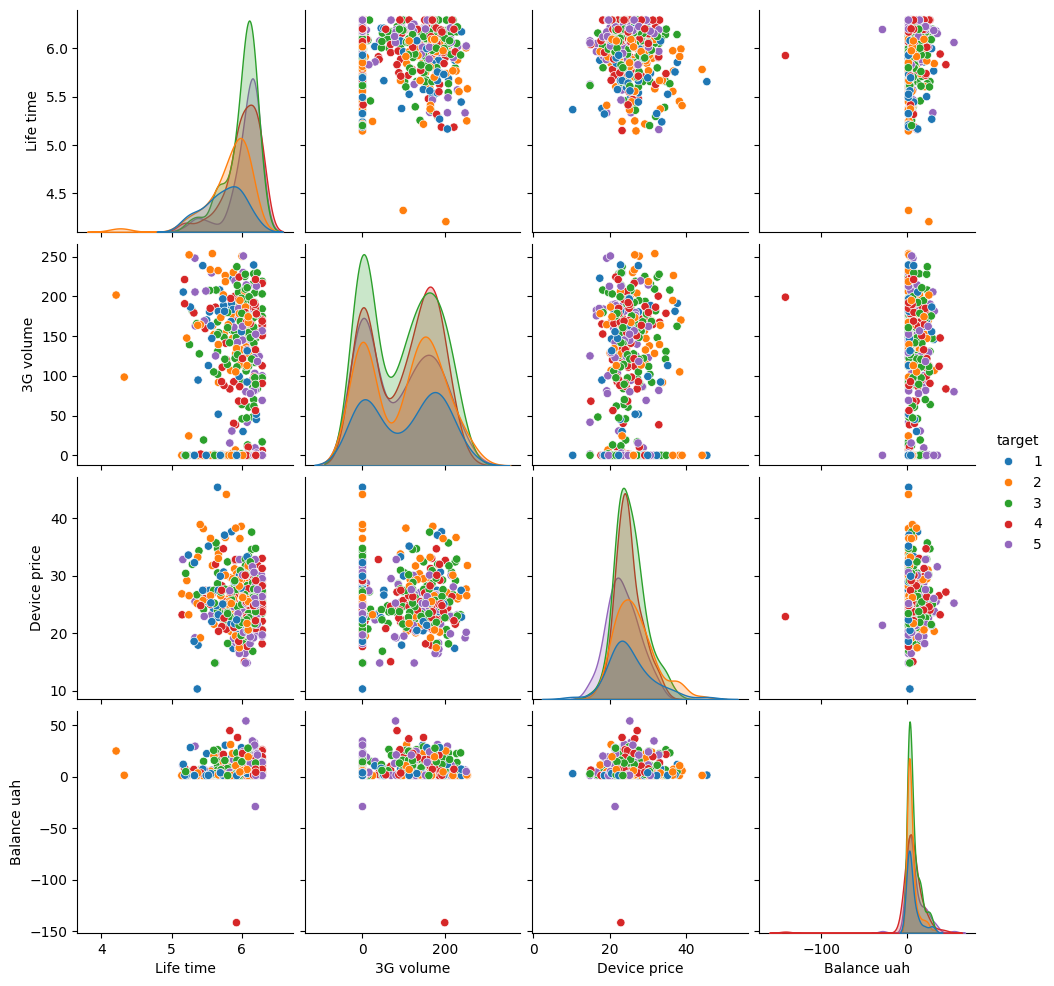

In [55]:
sampled_df = X_eda.sample(n=500, random_state=42)  
sns.pairplot(sampled_df, hue="target", palette="tab10")
plt.show()